#  Stock Movements Prediction Using Financial News
By Lin Shi, Yining Chen, Heyang Huang



##  Table of Contents
* Introduction
* Market Data Cleansing and Analysis
    * Exploratory Data Analysis   
        * [Plot Data Versus Time](#pdvt)
        * [Raw VS Adjusted Values ](#diff)
        * [Asset  Info](#asset)
        * [Crises](#crises)
        * [Price Volatility](#pv)
    * [Data Cleansing](#preprocessing)
    * [Data Selection](#ds)
    * [Final Dataset](#final)
* News Data Cleansing and Analysis
 * [News Data Cleaning](#NDC)
 * [News Data Processing](#NDP)
 * News Data Features  
       * [Top New Resources](#TNR)
       * [Correlation Heat Map](#CHM)
       * [Distribution of Sentiments](#DS)
       * [Word Cloud](#WC)
       * [Top Mention Companies](#TMC)
   
* Machine Learning Model
    * [Merge Data](#MD)
    * [Setup](#SU)
    * [Initiating Algorithms](#IA)
    * [Fitting Algorithms](#FA)
    * [Stacking Algorithms](#SA)
    * [Final Predictions](#FP)
* Conclusions  



# Introduction
Can we use the content of news analytics to predict stock price performance? People have been interested in making profits from financial stock market prediction. However, stock market forecast has always been a challenging problem because of its uncertainty and volatility. In this project, we will predict predict future stock returns based on two sources of data:
 * Market data (2007 to present) provided by Intrinio - contains financial market information such as opening price, closing price, trading volume, calculated returns, etc.
 * News data (2007 to present) Source: Thomson Reuters - contains information about news articles/alerts published about assets, such as article details, sentiment, and other commentary.



# Market Data Cleansing and Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import datetime
import matplotlib.pyplot as plt
import matplotlib
import re
from scipy import stats

matplotlib.rcParams['figure.figsize'] = (10, 5)
matplotlib.rcParams['font.size'] = 12

import random
random.seed(1)
import time

import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import get_scorer
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.ensemble import VotingClassifier
from sklearn.externals.joblib import Parallel, delayed
from sklearn.base import clone

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import datetime
import lightgbm as lgb
from scipy import stats
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
stop = set(stopwords.words('english'))


import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn import model_selection
from sklearn.metrics import accuracy_score

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
matplotlib.rcParams['figure.figsize'] = (10, 5)
matplotlib.rcParams['font.size'] = 12

In [2]:
from kaggle.competitions import twosigmanews
# You can only call make_env() once, so don't lose it!
env = twosigmanews.make_env()
print('Done!')

Loading the data... This could take a minute.
Done!
Done!


<a id='load_data'></a>

## Load the data

In [5]:
(market_train_df, news_train_df) = env.get_training_data()

<a id='explore_market'></a>

## Explore market data

In [6]:
print('Check null data:')
market_train_df.isna().sum()

Check null data:


time                            0
assetCode                       0
assetName                       0
volume                          0
close                           0
open                            0
returnsClosePrevRaw1            0
returnsOpenPrevRaw1             0
returnsClosePrevMktres1     15980
returnsOpenPrevMktres1      15988
returnsClosePrevRaw10           0
returnsOpenPrevRaw10            0
returnsClosePrevMktres10    93010
returnsOpenPrevMktres10     93054
returnsOpenNextMktres10         0
universe                        0
dtype: int64

**Some preprocessing:**
* Sort data in chronological order
* All NAN data comes from the market adjusted column. We fill them up with the raw value data

In [7]:
# Sort data
market_train_df = market_train_df.sort_values('time')
market_train_df['date'] = market_train_df['time'].dt.date

# Fill nan
market_train_fill = market_train_df
column_market = ['returnsClosePrevMktres1','returnsOpenPrevMktres1','returnsClosePrevMktres10', 'returnsOpenPrevMktres10']
column_raw = ['returnsClosePrevRaw1', 'returnsOpenPrevRaw1','returnsClosePrevRaw10', 'returnsOpenPrevRaw10']
for i in range(len(column_raw)):
    market_train_fill[column_market[i]] = market_train_fill[column_market[i]].fillna(market_train_fill[column_raw[i]])

<a id='pdvt'></a>
## Plot data versus time

Text(0.5,1,'Market close price by quantile')

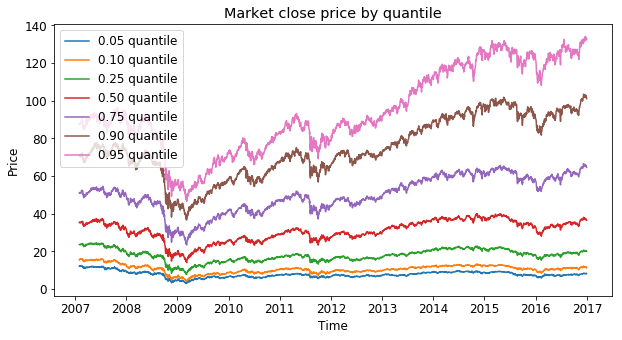

In [8]:

for i in [0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]:
    price_df = market_train_fill.groupby('date')['close'].quantile(i).reset_index()
    plt.plot(price_df['date'], price_df['close'], label='%.2f quantile' %i)
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Market close price by quantile')

Text(0.5,1,'returnsClosePrevRaw1 by quantile')

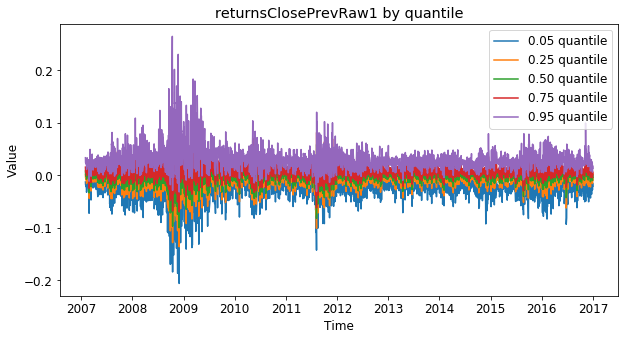

In [9]:
for i in [0.05, 0.25, 0.5, 0.75, 0.95]:
    price_df = market_train_fill.groupby('date')['returnsClosePrevRaw1'].quantile(i).reset_index()
    plt.plot(price_df['date'], price_df['returnsClosePrevRaw1'], label='%.2f quantile' %i)
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('returnsClosePrevRaw1 by quantile')


Text(0.5,1,'returnsOpenPrevRaw10 by quantiles')

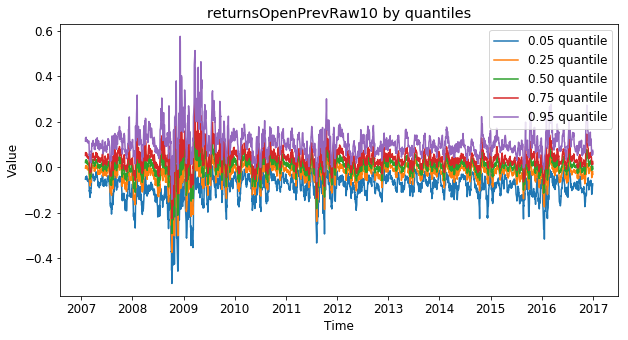

In [10]:
for i in [0.05, 0.25, 0.5, 0.75, 0.95]:
    price_df = market_train_fill.groupby('date')['returnsOpenPrevRaw10'].quantile(i).reset_index()
    plt.plot(price_df['date'], price_df['returnsOpenPrevRaw10'], label='%.2f quantile' %i)
plt.legend(loc=1)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('returnsOpenPrevRaw10 by quantiles')

Text(0.5,1,'returnsOpenPrevMktres10 by quantiles')

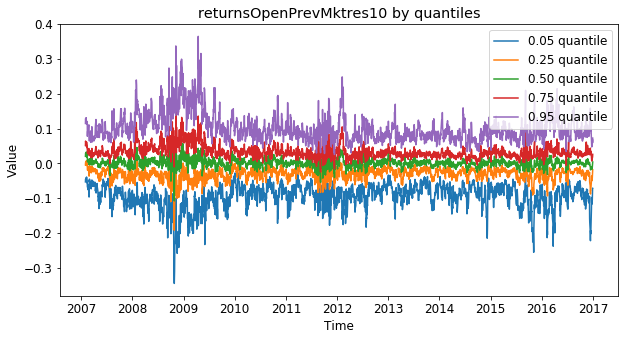

In [11]:
for i in [0.05, 0.25, 0.5, 0.75, 0.95]:
    price_df = market_train_fill.groupby('date')['returnsOpenPrevMktres10'].quantile(i).reset_index()
    plt.plot(price_df['date'], price_df['returnsOpenPrevMktres10'], label='%.2f quantile' %i)
plt.legend(loc=1)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('returnsOpenPrevMktres10 by quantiles')

Text(0.5,1,'returnsOpenNextMktres10 by quantiles')

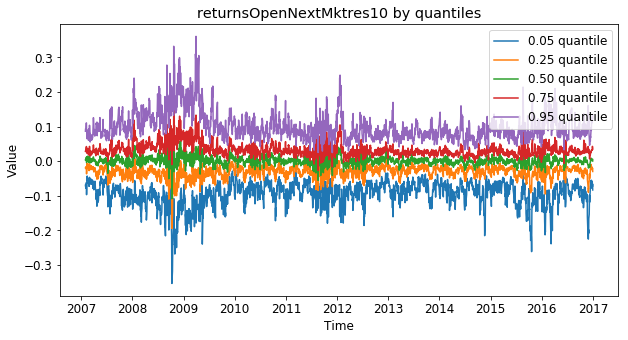

In [12]:
for i in [0.05, 0.25, 0.5, 0.75, 0.95]:
    price_df = market_train_fill.groupby('date')['returnsOpenNextMktres10'].quantile(i).reset_index()
    plt.plot(price_df['date'], price_df['returnsOpenNextMktres10'], label='%.2f quantile' %i)
plt.legend(loc=1)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('returnsOpenNextMktres10 by quantiles')

Text(0.5,1,'Market trade volumes by quantile')

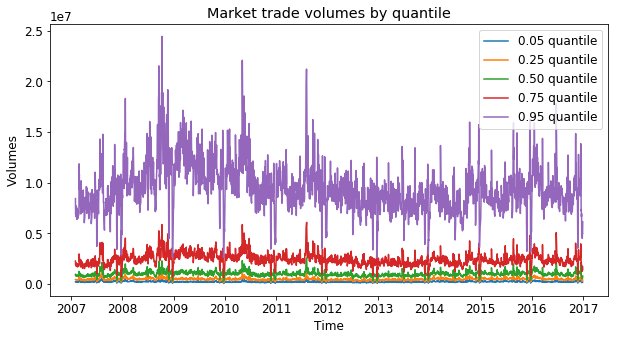

In [13]:
for i in [0.05, 0.25, 0.5, 0.75, 0.95]:
    price_df = market_train_fill.groupby('date')['volume'].quantile(i).reset_index()
    plt.plot(price_df['date'], price_df['volume'], label='%.2f quantile' %i)
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('Volumes')
plt.title('Market trade volumes by quantile')

<a id='diff'></a>
## Difference between raw values and market adjusted values

Let's see if there's any difference between raw return and market adjusted return

In [14]:
column_mkt_raw_diff = []
for i in range(len(column_market)):
    this_raw = column_raw[i]
    this_market = column_market[i]
    new_column_name = 'mkt_raw_diff'+this_raw.replace('returns','').replace('Raw','')
    column_mkt_raw_diff.append(new_column_name)
    market_train_fill[new_column_name] = market_train_fill[this_market] - market_train_fill[this_raw]

In [15]:
market_train_fill[column_mkt_raw_diff].describe()

mkt_raw_diffClosePrev1           ...            mkt_raw_diffOpenPrev10
count            4.072956e+06           ...                      4.072956e+06
mean            -3.687495e-04           ...                      1.004762e-03
std              1.703633e-02           ...                      2.475803e+00
min             -1.274218e+00           ...                     -1.977137e+03
25%             -6.087382e-03           ...                     -2.203994e-02
50%             -3.476470e-04           ...                     -1.699783e-03
75%              4.565655e-03           ...                      1.263982e-02
max              2.506964e+00           ...                      8.141942e+02

[8 rows x 4 columns]

The difference between raw return and market adjusted returns are negligible, but there are some extreme values. Those values are noise and needs to be taken care of

<a id='asset'></a>
## Asset codes

In [16]:
assetCode_df = market_train_df.groupby('assetCode')['volume'].sum().sort_values(ascending=False)
print('There are %i unique asset code' %len(assetCode_df))

There are 3780 unique asset code


In [17]:
unknown_name = market_train_fill[market_train_fill['assetName']=='Unknown']
unknown_count = unknown_name['assetCode'].value_counts().sort_values(ascending=False)

In [18]:
print('There are %i unique asset code with unknown asset name' %len(unknown_count))

There are 110 unique asset code with unknown asset name


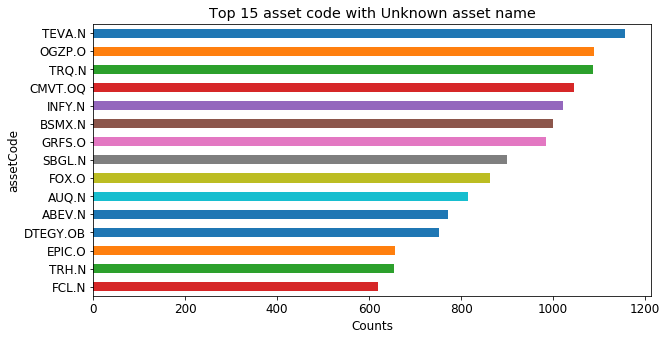

In [19]:
unknown_count[:15].plot.barh()
plt.ylabel('assetCode')
plt.xlabel('Counts')
plt.title('Top 15 asset code with Unknown asset name')
plt.gca().invert_yaxis()

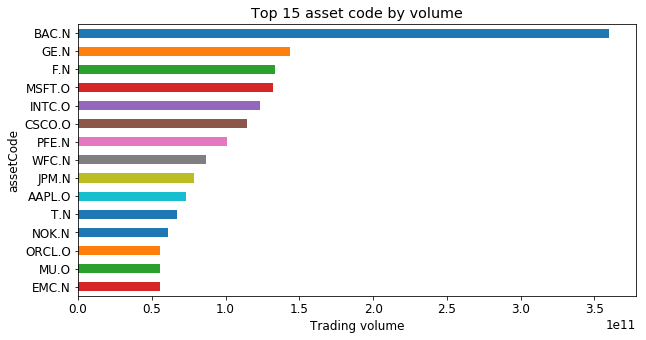

In [20]:
assetCode_df[:15].plot.barh()
plt.ylabel('assetCode')
plt.xlabel('Trading volume')
plt.title('Top 15 asset code by volume')
plt.gca().invert_yaxis()

##  Asset Name

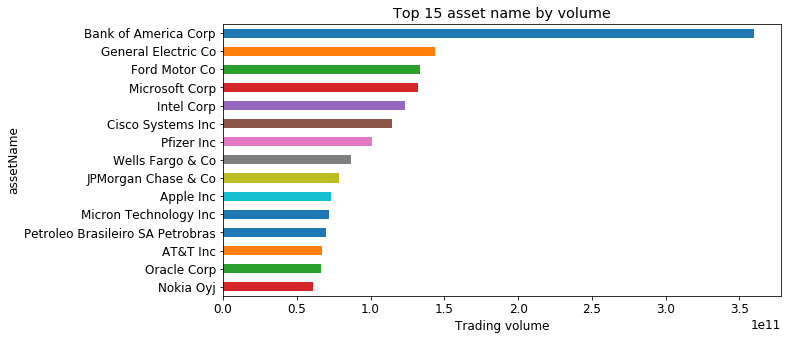

In [21]:
assetName_Volume = market_train_df.groupby('assetName')['volume'].sum().sort_values(ascending=False)
assetName_Volume[:15].plot.barh()
plt.ylabel('assetName')
plt.xlabel('Trading volume')
plt.title('Top 15 asset name by volume')
plt.gca().invert_yaxis()
del assetName_Volume

The volume ranking by coorperation seems to be the same as the rank of asset codes they own, e.g. the one with most popular codes has the most trading volume

In [22]:
assetName_code = market_train_df.groupby('assetName')['assetCode'].nunique().reset_index().sort_values(by='assetCode',ascending=False)

In [23]:
assetCodeCount = assetName_code.groupby('assetCode')['assetName'].count().reset_index()
assetCodeCount.columns = ['assetCodeNo', 'counts']
assetCodeCount.head()
del assetCodeCount

**The vast majority of companies has only one asset code**. One '*company*' that has 110 actually is the  'Unknown' category. Magically, some companies don't even have any asset code. Currently I have no explanation for this.

## Correlations

Text(0.5,1,'Pair-wise correlation')

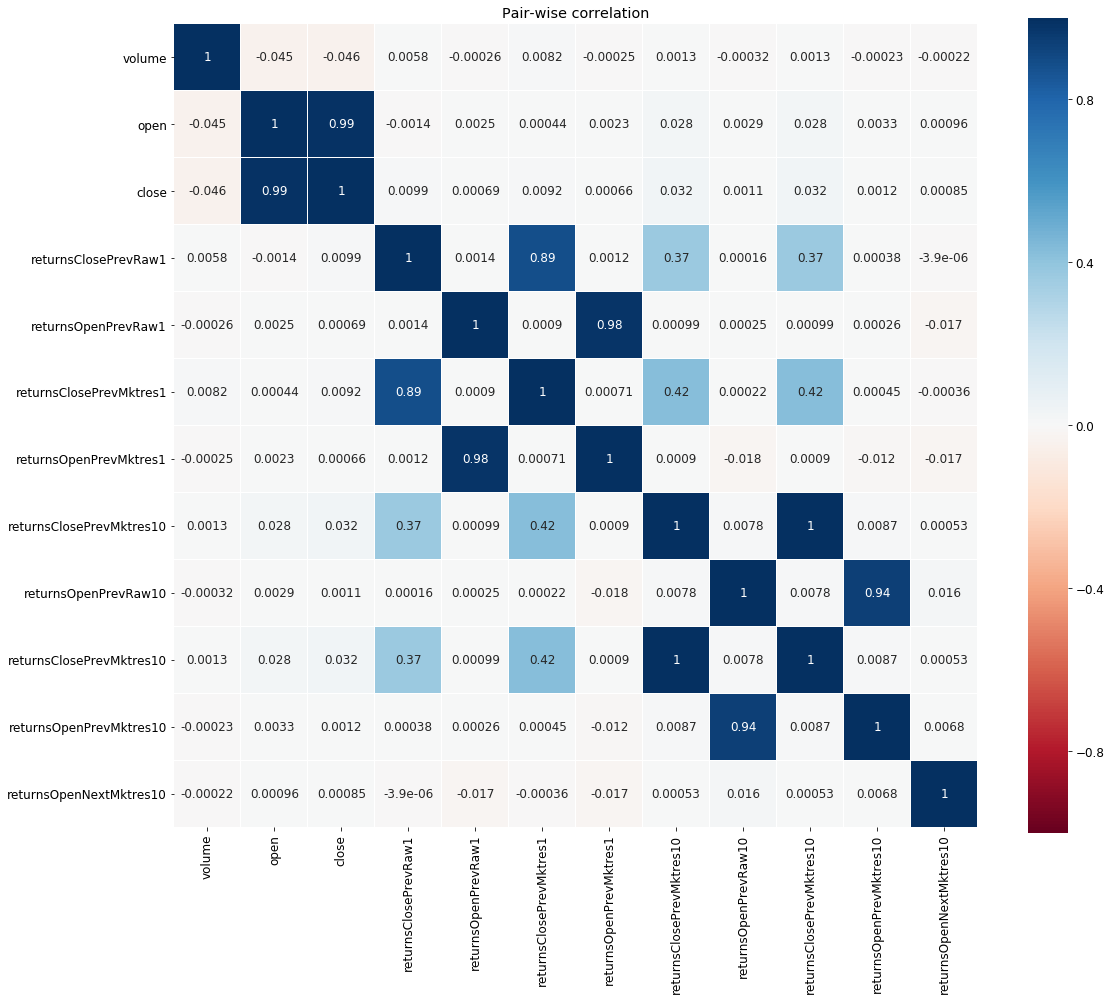

In [24]:
columns_corr_market = ['volume', 'open', 'close','returnsClosePrevRaw1','returnsOpenPrevRaw1',\
           'returnsClosePrevMktres1','returnsOpenPrevMktres1','returnsClosePrevMktres10','returnsOpenPrevRaw10',\
           'returnsClosePrevMktres10', 'returnsOpenPrevMktres10', 'returnsOpenNextMktres10']
colormap = plt.cm.RdBu
plt.figure(figsize=(18,15))
sns.heatmap(market_train_fill[columns_corr_market].astype(float).corr(), linewidths=0.1, vmax=1.0, vmin=-1., square=True, cmap=colormap, linecolor='white', annot=True)
plt.title('Pair-wise correlation')

<a id='crises'></a>
## Economic Crises

In [25]:
data = []
for i in [0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]:
    price_df = market_train_df.groupby('time')['close'].quantile(i).reset_index()

    data.append(go.Scatter(
        x = price_df['time'].dt.strftime(date_format='%Y-%m-%d').values,
        y = price_df['close'].values,
        name = f'{i} quantile'
    ))
layout = go.Layout(dict(title = "Trends of closing prices by quantiles",
                  xaxis = dict(title = 'Month'),
                  yaxis = dict(title = 'Price (USD)'),
                  ),legend=dict(
                orientation="h"),
    annotations=[
        dict(
            x='2008-09-01 22:00:00+0000',
            y=82,
            xref='x',
            yref='y',
            text='2008 Global Crisis',
            showarrow=True,
            font=dict(
                family='Courier New, monospace',
                size=16,
                color='#ffffff'
            ),
            align='center',
            arrowhead=2,
            arrowsize=1,
            arrowwidth=2,
            arrowcolor='#636363',
            ax=20,
            ay=-30,
            bordercolor='#c7c7c7',
            borderwidth=2,
            borderpad=4,
            bgcolor='#ff7f0e',
            opacity=0.8
        ),
        dict(
            x='2011-08-01 22:00:00+0000',
            y=85,
            xref='x',
            yref='y',
            text='2011 Black Monday',
            showarrow=True,
            font=dict(
                family='Courier New, monospace',
                size=16,
                color='#ffffff'
            ),
            align='center',
            arrowhead=2,
            arrowsize=1,
            arrowwidth=2,
            arrowcolor='#636363',
            ax=20,
            ay=-30,
            bordercolor='#c7c7c7',
            borderwidth=2,
            borderpad=4,
            bgcolor='#ff7f0e',
            opacity=0.8
        ),
        dict(
            x='2014-10-01 22:00:00+0000',
            y=120,
            xref='x',
            yref='y',
            text='2014 Russian Crisis',
            showarrow=True,
            font=dict(
                family='Courier New, monospace',
                size=16,
                color='#ffffff'
            ),
            align='center',
            arrowhead=2,
            arrowsize=1,
            arrowwidth=2,
            arrowcolor='#636363',
            ax=-20,
            ay=-30,
            bordercolor='#c7c7c7',
            borderwidth=2,
            borderpad=4,
            bgcolor='#ff7f0e',
            opacity=0.8
        ),
        dict(
            x='2016-01-01 22:00:00+0000',
            y=120,
            xref='x',
            yref='y',
            text='2016 Oil prices crash',
            showarrow=True,
            font=dict(
                family='Courier New, monospace',
                size=16,
                color='#ffffff'
            ),
            align='center',
            arrowhead=2,
            arrowsize=1,
            arrowwidth=2,
            arrowcolor='#636363',
            ax=20,
            ay=-30,
            bordercolor='#c7c7c7',
            borderwidth=2,
            borderpad=4,
            bgcolor='#ff7f0e',
            opacity=0.8
        )
    ])
py.iplot(dict(data=data, layout=layout), filename='basic-line')

<a id='pv'></a>
## Price Volatility

In [26]:
market_train_df['price_diff'] = market_train_df['close'] - market_train_df['open']
grouped = market_train_df.groupby('time').agg({'price_diff': ['std', 'min']}).reset_index()
g = grouped.sort_values(('price_diff', 'std'), ascending=False)[:10]
g['min_text'] = 'Maximum price drop: ' + (-1 * g['price_diff']['min']).astype(str)
trace = go.Scatter(
    x = g['time'].dt.strftime(date_format='%Y-%m-%d').values,
    y = g['price_diff']['std'].values,
    mode='markers',
    marker=dict(
        size = g['price_diff']['std'].values,
        color = g['price_diff']['std'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = g['min_text'].values
    #text = f"Maximum price drop: {g['price_diff']['min'].values}"
    #g['time'].dt.strftime(date_format='%Y-%m-%d').values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Top 10 months by standard deviation of price change within a day',
    hovermode= 'closest',
    yaxis=dict(
        title= 'price_diff',
        ticklen= 5,
        gridwidth= 2,
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

<a id='preprocessing'></a>

## Data Cleansing

### Market data
* **Outliers - Open to close:** the difference between open price and close price cannot be too much difference (market would corrupt otherwise). We treat these outliers by clipping the close-to-open ratio

In [27]:
market_train_df.sort_values('price_diff')[:10]

time    ...     price_diff
1127598 2010-01-04 22:00:00+00:00    ...     -9948.9900
627547  2008-09-29 22:00:00+00:00    ...     -3261.6136
502997  2008-06-05 22:00:00+00:00    ...      -982.7000
471381  2008-05-06 22:00:00+00:00    ...      -938.9500
242847  2007-09-27 22:00:00+00:00    ...      -920.0000
3264631 2015-03-16 22:00:00+00:00    ...      -207.2100
7273    2007-02-08 22:00:00+00:00    ...      -110.4800
375899  2008-02-06 22:00:00+00:00    ...       -98.2400
628075  2008-09-29 22:00:00+00:00    ...       -77.5200
3565205 2015-11-20 22:00:00+00:00    ...       -75.8100

[10 rows x 22 columns]

![](http://)![](https://i.imgur.com/C3COWfe.png)

In [28]:
market_train_df['close_open_ratio'] = np.abs(market_train_df['close']/market_train_df['open'])
threshold = 0.5
print('In %i lines price increases by 50%% or more in a day' %(market_train_df['close_open_ratio']>=1.5).sum())
print('In %i lines price decreases by 50%% or more in a day' %(market_train_df['close_open_ratio']<=0.5).sum())

In 83 lines price increases by 50% or more in a day
In 16 lines price decreases by 50% or more in a day


In [29]:
market_train_df = market_train_df.loc[market_train_df['close_open_ratio'] < 1.5]
market_train_df = market_train_df.loc[market_train_df['close_open_ratio'] > 0.5]
market_train_df = market_train_df.drop(columns=['close_open_ratio'])

* **Fill nulls - Market values:** All null data comes from market adjusted columns. We fill them up with the raw values in the same row

In [30]:
column_market = ['returnsClosePrevMktres1','returnsOpenPrevMktres1','returnsClosePrevMktres10', 'returnsOpenPrevMktres10']
column_raw = ['returnsClosePrevRaw1', 'returnsOpenPrevRaw1','returnsClosePrevRaw10', 'returnsOpenPrevRaw10']
for i in range(len(column_raw)):
    market_train_df[column_market[i]] = market_train_df[column_market[i]].fillna(market_train_df[column_raw[i]])

* **Outliers-Returns:** Return should not exceed 50% or falls below 50%. If it does, it is either noise, or extreme data that will confuse our prediction later on. We remove these extreme data.

In [31]:
print('Removing outliers ...')
column_return = column_market + column_raw + ['returnsOpenNextMktres10']
orig_len = market_train_df.shape[0]
for column in column_return:
    market_train_df = market_train_df.loc[market_train_df[column]>=-2]
    market_train_df = market_train_df.loc[market_train_df[column]<=2]
new_len = market_train_df.shape[0]
rmv_len = np.abs(orig_len-new_len)
print('There were %i lines removed' %rmv_len)

Removing outliers ...
There were 809 lines removed


* **Remove strange data**: Here we remove data with unknown asset name or asset codes with strange behavior. For more details, see here: https://www.kaggle.com/nareyko/market-return-estimation-and-bad-data-detection

In [32]:
print('Removing strange data ...')
orig_len = market_train_df.shape[0]
market_train_df = market_train_df[~market_train_df['assetCode'].isin(['PGN.N','EBRYY.OB'])]
#market_train_df = market_train_df[~market_train_df['assetName'].isin(['Unknown'])]
new_len = market_train_df.shape[0]
rmv_len = np.abs(orig_len-new_len)
print('There were %i lines removed' %rmv_len)

Removing strange data ...
There were 531 lines removed


<a id='ds'></a>

## Data selection

Looking at the statistics, most data behave homogeneously after 2009 (volume increase, price increase, etc.). However, before 2010, due to the burst of the housing bubble that leads to the financial crisis in 2008, the data behaves differently. So the question to make the right prediction for this problem is: **Will there be a financial crisis in the next 6 months?** If the answer is **Yes**, then we include data before 2010. If the answer is **No**, then we exclude them.

 To make the dataset more representative, I choose **No** as the answer. 

In [33]:
market_train_df['price_diff'] = market_train_df['close'] - market_train_df['open']
grouped = market_train_df.groupby(['time']).agg({'price_diff': ['std', 'min']}).reset_index()
g = grouped.sort_values(('price_diff', 'std'), ascending=False)[:10]
g['min_text'] = 'Maximum price drop: ' + (-1 * np.round(g['price_diff']['min'], 2)).astype(str)
trace = go.Scatter(
    x = g['time'].dt.strftime(date_format='%Y-%m-%d').values,
    y = g['price_diff']['std'].values,
    mode='markers',
    marker=dict(
        size = g['price_diff']['std'].values * 5,
        color = g['price_diff']['std'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = g['min_text'].values
    #text = f"Maximum price drop: {g['price_diff']['min'].values}"
    #g['time'].dt.strftime(date_format='%Y-%m-%d').values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Top 10 months by standard deviation of price change within a day',
    hovermode= 'closest',
    yaxis=dict(
        title= 'price_diff',
        ticklen= 5,
        gridwidth= 2,
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

In [34]:
data = []
for i in [0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]:
    price_df = market_train_df.groupby('time')['returnsOpenNextMktres10'].quantile(i).reset_index()

    data.append(go.Scatter(
        x = price_df['time'].dt.strftime(date_format='%Y-%m-%d').values,
        y = price_df['returnsOpenNextMktres10'].values,
        name = f'{i} quantile'
    ))
layout = go.Layout(dict(title = "Trends of returnsOpenNextMktres10 by quantiles",
                  xaxis = dict(title = 'Month'),
                  yaxis = dict(title = 'Price (USD)'),
                  ),legend=dict(
                orientation="h"),)
py.iplot(dict(data=data, layout=layout), filename='basic-line')

<a id='final'></a>
## Final Market Dataset

In [35]:
data = []
market_train_df = market_train_df.loc[market_train_df['time'] >= '2010-01-01 22:00:00+0000']

price_df = market_train_df.groupby('time')['returnsOpenNextMktres10'].mean().reset_index()

data.append(go.Scatter(
    x = price_df['time'].dt.strftime(date_format='%Y-%m-%d').values,
    y = price_df['returnsOpenNextMktres10'].values,
    name = f'{i} quantile'
))
layout = go.Layout(dict(title = "Treand of returnsOpenNextMktres10 mean",
                  xaxis = dict(title = 'Month'),
                  yaxis = dict(title = 'Price (USD)'),
                  ),legend=dict(
                orientation="h"),)
py.iplot(dict(data=data, layout=layout), filename='basic-line')


# News Data Cleansing and Analysis


In [5]:
import pandas as pd
import numpy as np
import time
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette("coolwarm",7)
color2 = sns.cubehelix_palette(8)

plt.style.use('seaborn')
sns.set(font_scale=2)

import warnings 
warnings.filterwarnings('ignore')
import os

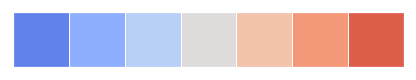

In [37]:
sns.palplot(color)

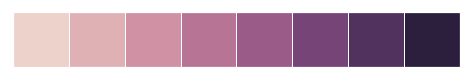

In [38]:
sns.palplot(color2)

In [3]:
(market_train_df, news_train_df) = env.get_training_data()

In [40]:
print("In total: ", news_train_df.shape)

In total:  (9328750, 35)


In [41]:
news_train_df.head()

time      ...       volumeCounts7D
0 2007-01-01 04:29:32+00:00      ...                    7
1 2007-01-01 07:03:35+00:00      ...                    3
2 2007-01-01 11:29:56+00:00      ...                   17
3 2007-01-01 12:08:37+00:00      ...                   15
4 2007-01-01 12:08:37+00:00      ...                    0

[5 rows x 35 columns]

<a id='NDC'></a>
## News Data cleaning - Convert empty values to Nan

In [5]:
# '' convert to NA
for i in news_train_df.columns.values.tolist():
    news_train_df[i] = news_train_df[i].replace('', np.nan)  
news_train_df['headlineTag'].unique()[0:5]

array([nan, 'FEATURE', 'PRESS DIGEST', 'RPT', 'TEXT'], dtype=object)

## Missing Values

Text(0.5,1,'Total Missing Value by news_train_df')

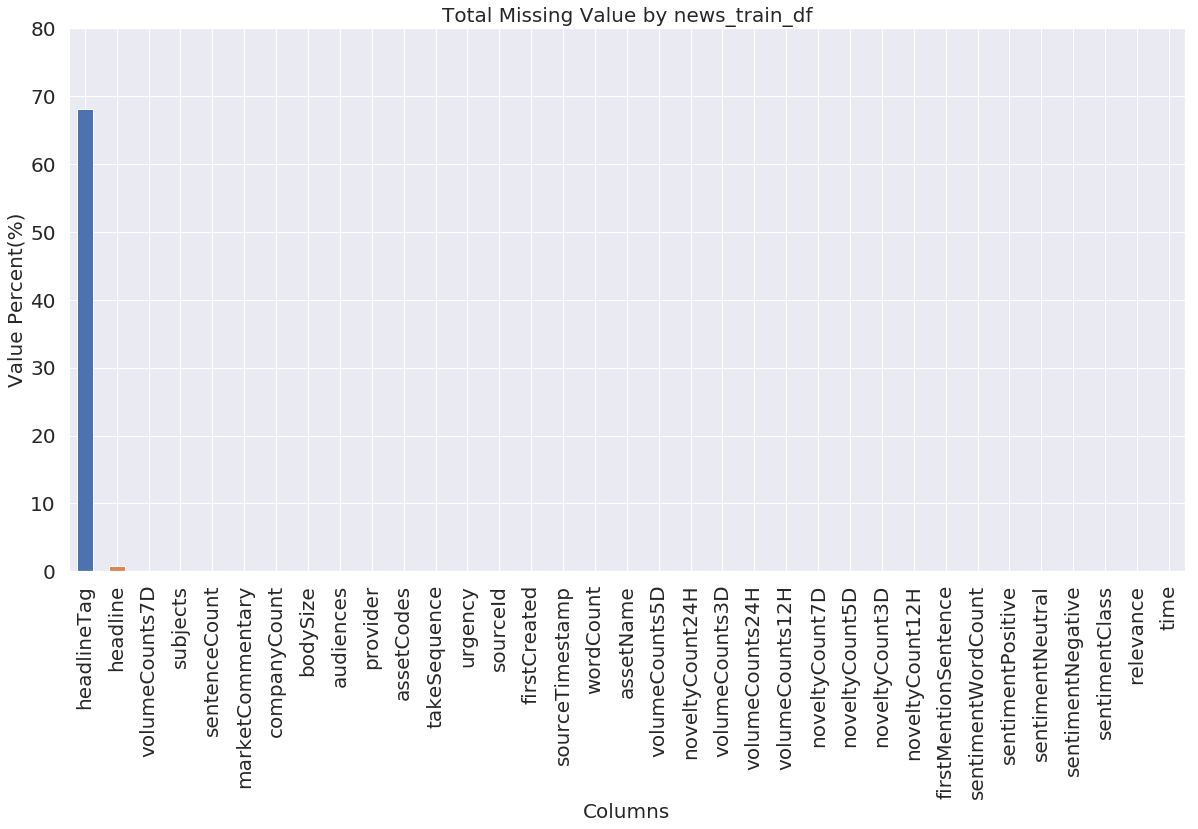

In [6]:
percent = (100 * news_train_df.isnull().sum() / news_train_df.shape[0]).sort_values(ascending=False)
percent.plot(kind="bar", figsize = (20,10), fontsize = 20)
plt.xlabel("Columns", fontsize = 20)
plt.ylabel("Value Percent(%)", fontsize = 20)
plt.ylim(0,80)
plt.title("Total Missing Value by news_train_df", fontsize = 20)

*Besides empty headline tags and a few missing headlines, the dataset is all good*

<a id='TNR'></a>
## Top news sources

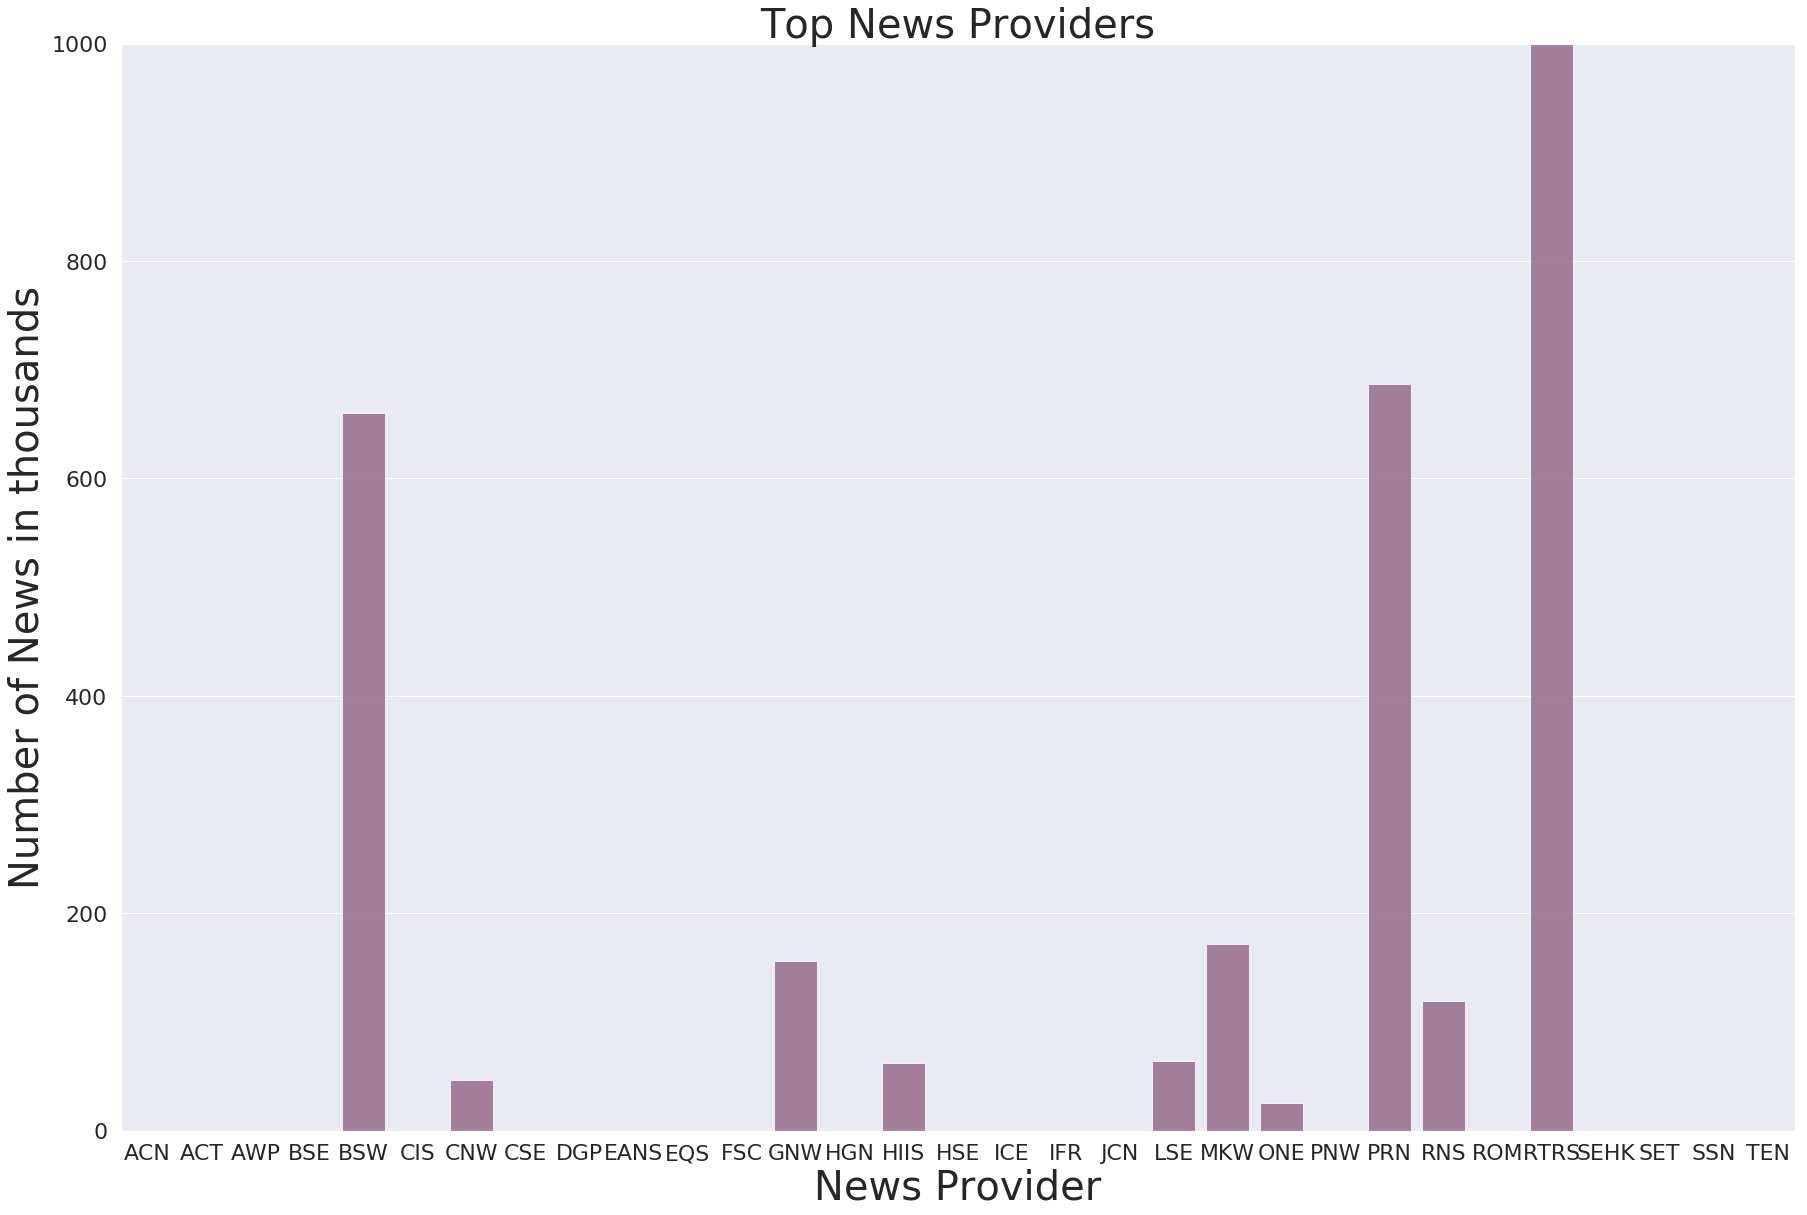

In [7]:
news_sources = news_train_df['provider'].value_counts().head(10)/1000
plt.figure(figsize=(30,20))
sns.barplot(news_sources.index, news_sources.values, alpha=0.8, color=color2[4])
plt.ylabel('Number of News in thousands', fontsize=40)
plt.xlabel('News Provider', fontsize=40)
plt.title("Top News Providers", fontsize = 40)
plt.ylim(0,1000)
plt.show()

*Reuters is the most common provider.*

<a id='TMC'></a>
## Top mentioned companies

In [8]:
plt.figure(figsize=(20,8))
for i, j,k in zip([-1, 0, 1], ['negative', 'neutral', 'positive'],[1, 2, 3]):
    df_sentiment = news_train_df.loc[news_train_df['sentimentClass'] == i, 'assetName']
    print(f'Top mentioned companies for {j} sentiment are:')
    print(df_sentiment.value_counts().head(5))
    print('')
    #plt.subplot(1, 3, k)
    #sns.barplot(df_sentiment.value_counts().head(10).index, df_sentiment.value_counts().head(10), alpha=0.8, color=color2[4])
    #print(df_sentiment.value_counts().head(10).index, df_sentiment.value_counts().head(10))
#plt.show()

Top mentioned companies for negative sentiment are:
Citigroup Inc              30823
JPMorgan Chase & Co        29129
Bank of America Corp       28197
Apple Inc                  26702
Goldman Sachs Group Inc    25044
Name: assetName, dtype: int64

Top mentioned companies for neutral sentiment are:
Barclays PLC         24898
HSBC Holdings PLC    23191
Deutsche Bank AG     20702
BHP Billiton PLC     18019
Rio Tinto PLC        16782
Name: assetName, dtype: int64

Top mentioned companies for positive sentiment are:
Barclays PLC             22855
Apple Inc                22770
General Electric Co      20055
Royal Dutch Shell PLC    18206
Citigroup Inc            18025
Name: assetName, dtype: int64



<Figure size 1440x576 with 0 Axes>

<a id='DS'></a>
## Distribution of sentiment values

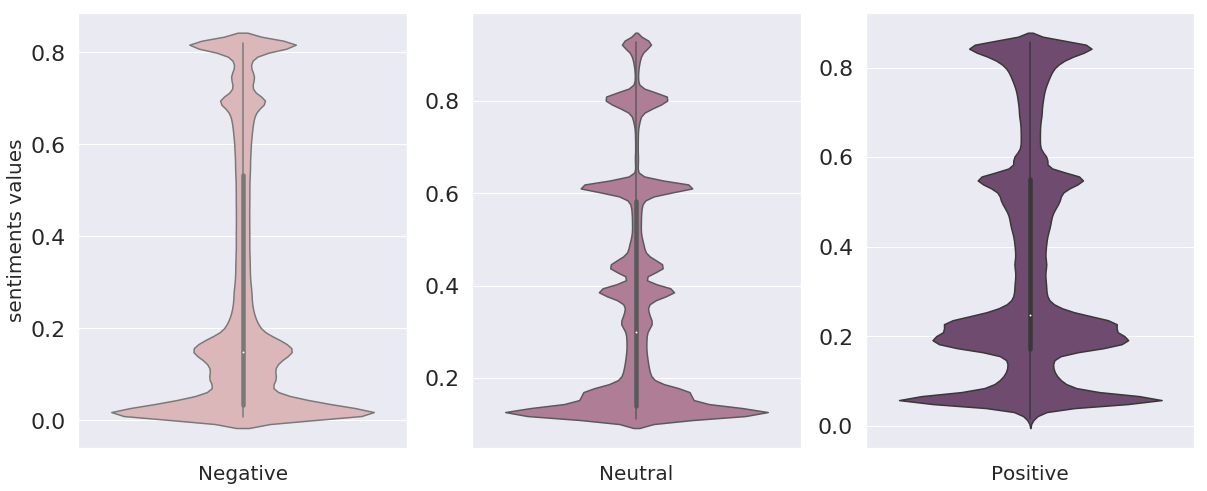

In [9]:
plt.figure(figsize=(20,8))

plt.subplot(1, 3, 1)
sns.violinplot(y = 'sentimentNegative', data = news_train_df, color = color2[1])
plt.xlabel('Negative', fontsize=20)
plt.ylabel('sentiments values', fontsize=20)

plt.subplot(1, 3, 2)
sns.violinplot(y = 'sentimentNeutral', data = news_train_df, color = color2[3])
plt.xlabel('Neutral', fontsize=20)
plt.ylabel(' ', fontsize=20)

plt.subplot(1, 3, 3)
sns.violinplot(y = 'sentimentPositive', data = news_train_df, color = color2[5])
plt.xlabel('Positive', fontsize=20)
plt.ylabel(' ', fontsize=20)
plt.show()

*Sentiment values are distributed quite evenly, with peaks at 0, 0.2, 0.4, and 0.8*

<a id='CHM'></a>
## Correlation heatmap of News Data

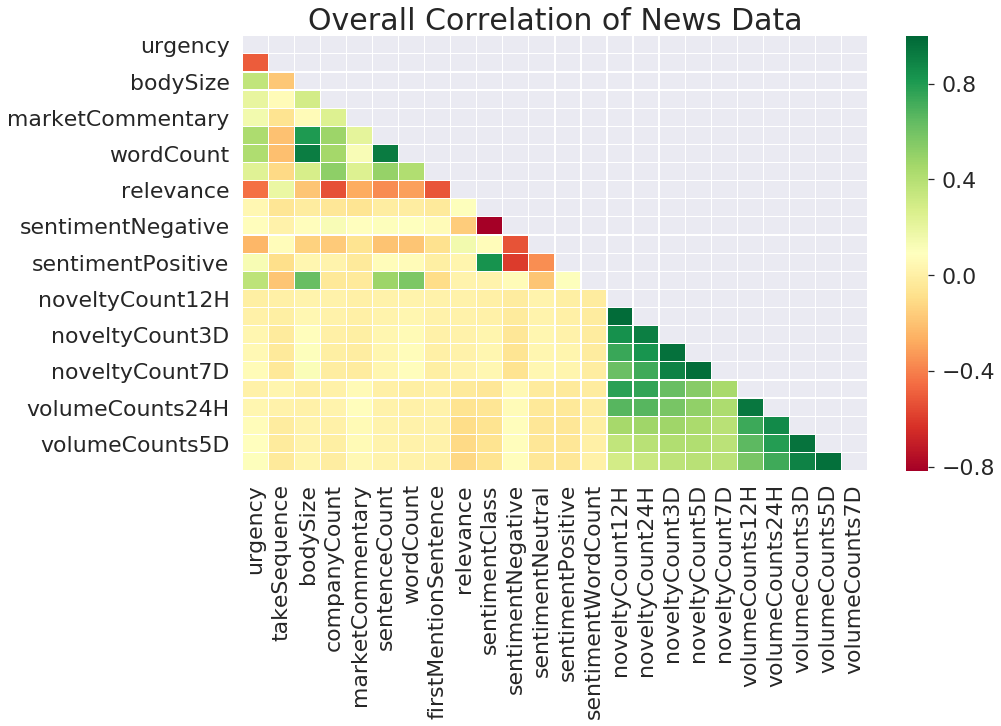

In [6]:
# Initiate correlation matrix
corr = news_train_df.corr()
# Set-up mask
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Set-up figure
plt.figure(figsize=(14, 8))
# Title
plt.title('Overall Correlation of News Data', fontsize=30)
# Correlation matrix
sns.heatmap(corr, mask=mask, annot=False,cmap='RdYlGn', linewidths=0.2, annot_kws={'size':20})
plt.show()

<a id='NDP'></a>
## Data Processing

In [7]:
class model():
    def __init__(self, market, news, verbose=False):
        self.market = market.sort_values('time')
        self.news = news.sort_values('time')
        self.verbose = verbose
        self._format_dates()
        self._convert_booleans()
    #________________________________________________________________________
    # detection of columns with dates and times, then reduced to single dates
    def _format_dates(self):
        for df in [self.market, self.news]:
            datetime_cols = [c for c in df.columns if 'date' in str(df[c].dtypes)]
            for col in datetime_cols:
                df[col] = df[col].dt.normalize()
                if self.verbose: 
                    print ("Content of column:'{}' set as date".format(col))
    #_________________________________
    # convert booleans columns to int
    def _convert_booleans(self):
        for col in self.news.columns:
            if self.news[col].dtype == bool: 
                self.news[col] = self.news[col].astype(int)

In [8]:
project_model =  model(market_train_df, news_train_df, verbose=True)

Content of column:'time' set as date
Content of column:'time' set as date
Content of column:'sourceTimestamp' set as date
Content of column:'firstCreated' set as date


## Keep data after 2010

In [9]:
import datetime
import pytz
def select_dates(self, first_date):
    self.market = self.market.loc[self.market['time'] >= first_date]
    self.news = self.news.loc[self.news['time'] >= first_date]
    if self.verbose:
        print("data before '{}' has been removed".format(first_date))
#______________________________________________________________________
project_model.select_dates = select_dates.__get__(project_model)
project_model.select_dates(datetime.datetime(2010, 1, 1, 0, 0, 0, 0, pytz.UTC))

data before '2010-01-01 00:00:00+00:00' has been removed


<a id='WC'></a>
## Wordcloud of headlines about Google, Apple, Goldman Sachs, and Wal-mart

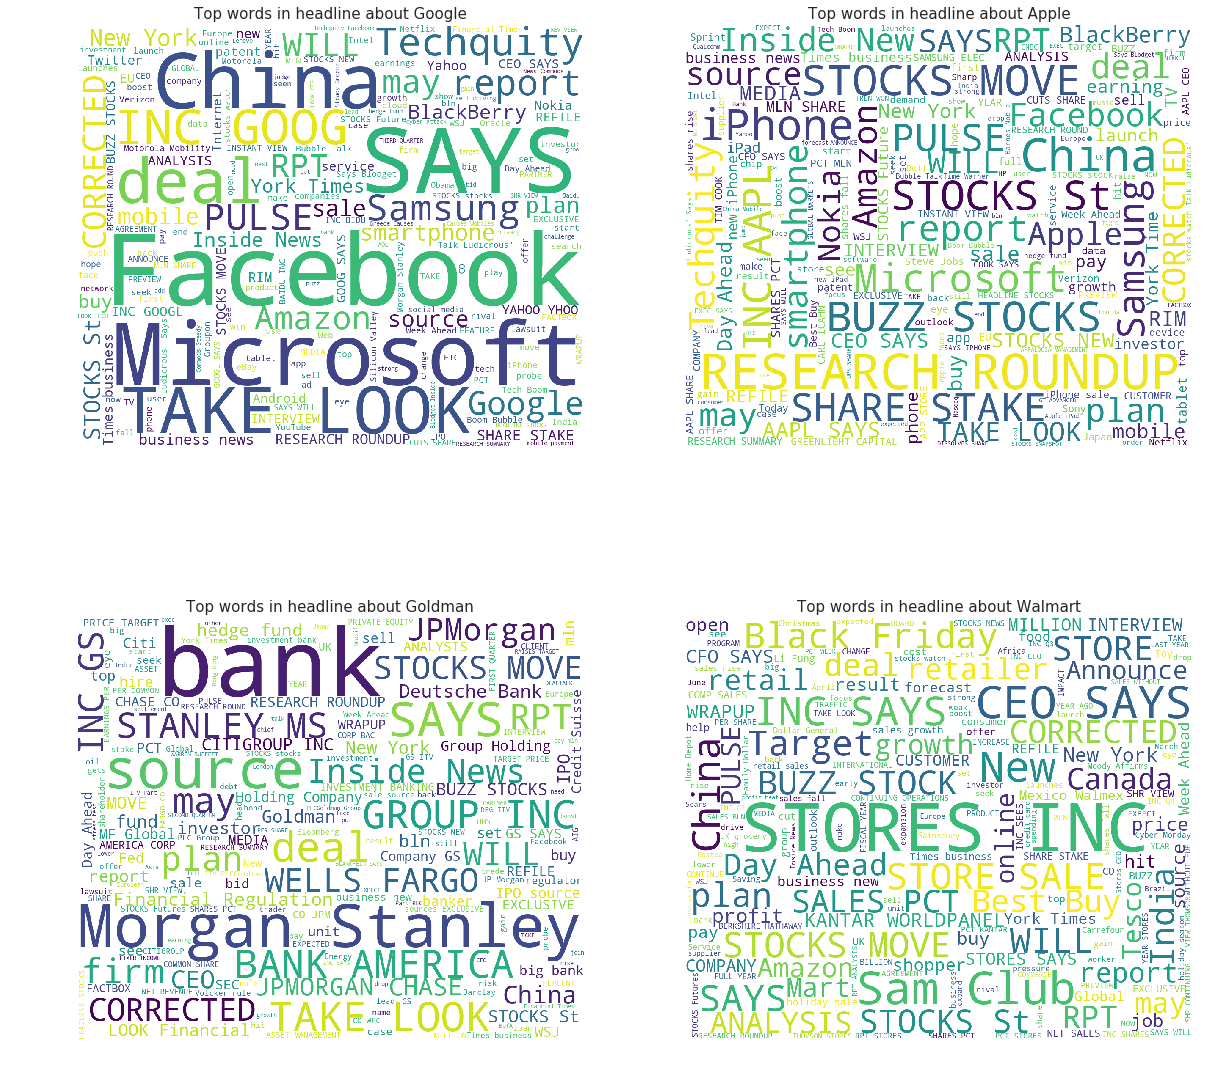

In [10]:
from IPython.display import IFrame
from os import path
from wordcloud import WordCloud, STOPWORDS

text_google = " ".join (str(v) for v in project_model.news[project_model.news['assetName'] == 'Google Inc']['headline'])
text_apple = " ".join (str(v) for v in project_model.news[project_model.news['assetName'] == 'Apple Inc']['headline'])
text_goldman = " ".join (str(v) for v in project_model.news[project_model.news['assetName'] == 'Goldman Sachs Group Inc']['headline'])
text_walmart = " ".join (str(v) for v in project_model.news[project_model.news['assetName'] == 'Wal-Mart Stores Inc']['headline'])
stopwords = set(STOPWORDS)
for i in ["google", "goldman", "sach", "sachs", "reuters", "insider", "apple","walmart", "wal", "mart", "update", "press", "digest", "wall", "street", "market", "trading", "noon", "morning", "call", "breakingviews", "us", "stock" ,"say", "syas", "wmt", "brief"]:
    stopwords.add(i)

wordcloud_google = WordCloud(max_font_size=None, stopwords=stopwords, background_color='white',width=1200, height=1000).generate(text_google)
wordcloud_apple = WordCloud(max_font_size=None, stopwords=stopwords, background_color='white',width=1200, height=1000).generate(text_apple)
wordcloud_goldman = WordCloud(max_font_size=None, stopwords=stopwords, background_color='white',width=1200, height=1000).generate(text_goldman)
wordcloud_walmart = WordCloud(max_font_size=None, stopwords=stopwords, background_color='white',width=1200, height=1000).generate(text_walmart)
plt.figure(figsize=(20, 20))

plt.subplot(2, 2, 1)
plt.imshow(wordcloud_google)
plt.title('Top words in headline about Google', fontsize = 15)
plt.axis("off")

plt.subplot(2, 2, 2)
plt.imshow(wordcloud_apple)
plt.title('Top words in headline about Apple', fontsize = 15)
plt.axis("off")

plt.subplot(2, 2, 3)
plt.imshow(wordcloud_goldman)
plt.title('Top words in headline about Goldman', fontsize = 15)
plt.axis("off")

plt.subplot(2, 2, 4)
plt.imshow(wordcloud_walmart)
plt.title('Top words in headline about Walmart', fontsize = 15)
plt.axis("off")

plt.show()



# Machine Learning

<a id='MD'></a>

## Merge Data
Here we make a function process both market and news data, then merge them.


In [ ]:
asset_code_dict = {k: v for v, k in enumerate(market_train_df['assetCode'].unique())}
drop_columns = [col for col in news_train_df.columns if col not in ['sourceTimestamp', 'urgency', 'takeSequence', 'bodySize', 'companyCount', 
               'sentenceCount', 'firstMentionSentence', 'relevance','firstCreated', 'assetCodes']]
columns_news = ['firstCreated','relevance','sentimentClass','sentimentNegative','sentimentNeutral',
               'sentimentPositive','noveltyCount24H','noveltyCount7D','volumeCounts24H','volumeCounts7D','assetCodes','sourceTimestamp',
               'assetName','audiences', 'urgency', 'takeSequence', 'bodySize', 'companyCount', 
               'sentenceCount', 'firstMentionSentence','time']

In [ ]:
# Data processing function
def data_prep(market_df,news_df):
    market_df['date'] = market_df.time.dt.date
    market_df['close_to_open'] = market_df['close'] / market_df['open']
    market_df.drop(['time'], axis=1, inplace=True)
    
    news_df = news_df[columns_news]
    news_df['sourceTimestamp']= news_df.sourceTimestamp.dt.hour
    news_df['firstCreated'] = news_df.firstCreated.dt.date
    news_df['assetCodesLen'] = news_df['assetCodes'].map(lambda x: len(eval(x)))
    news_df['assetCodes'] = news_df['assetCodes'].map(lambda x: list(eval(x))[0])
    news_df['asset_sentiment_count'] = news_df.groupby(['assetName', 'sentimentClass'])['time'].transform('count')
    news_df['len_audiences'] = news_train_df['audiences'].map(lambda x: len(eval(x)))
    kcol = ['firstCreated', 'assetCodes']
    news_df = news_df.groupby(kcol, as_index=False).mean()
    market_df = pd.merge(market_df, news_df, how='left', left_on=['date', 'assetCode'], 
                            right_on=['firstCreated', 'assetCodes'])
    del news_df
    market_df['assetCodeT'] = market_df['assetCode'].map(asset_code_dict)
    market_df = market_df.drop(columns = ['firstCreated','assetCodes','assetName']).fillna(0) 
    return market_df

In [ ]:
print('Merging data ...')
market_train_df = data_prep(market_train_df, news_train_df)
market_train_df.head()

We then perform feature selection . Feature scaling is not needed since we plan to use lightgbm - a tree-based model, which do not require standardization.

I tried using a regressor model, but a problem is that it gives close-to-0 values for most of prediction. Thus, I convert this problem into a classification problem: 0 for negative return and 1 for positive return

In [ ]:
num_columns = ['volume', 'close', 'open', 'returnsClosePrevRaw1', 'returnsOpenPrevRaw1', 'returnsClosePrevMktres1', 'returnsOpenPrevMktres1', 'returnsClosePrevRaw10', 'returnsOpenPrevRaw10', 
               'returnsClosePrevMktres10', 'returnsOpenPrevMktres10', 'close_to_open', 'sourceTimestamp', 'urgency', 'companyCount', 'takeSequence', 'bodySize', 'sentenceCount',
               'relevance', 'sentimentClass', 'sentimentNegative', 'sentimentNeutral', 'sentimentPositive',
               'noveltyCount24H','noveltyCount7D','volumeCounts24H','volumeCounts7D','assetCodesLen', 'asset_sentiment_count', 'len_audiences']
cat_columns = ['assetCodeT']
feature_columns = num_columns+cat_columns

In [ ]:
# Scaling of data
from sklearn.preprocessing import StandardScaler, MinMaxScaler

data_scaler = StandardScaler()
#market_train_df[num_columns] = data_scaler.fit_transform(market_train_df[num_columns])
#data_scaler = MinMaxScaler()
market_train_df[num_columns] = data_scaler.fit_transform(market_train_df[num_columns])

In [ ]:
from sklearn.model_selection import train_test_split

market_train_df = market_train_df.reset_index()
market_train_df = market_train_df.drop(columns='index')

# Random train-test split
train_indices, val_indices = train_test_split(market_train_df.index.values,test_size=0.1, random_state=92)

In [ ]:
# Extract X and Y
def get_input(market_train, indices):
    X = market_train.loc[indices, feature_columns].values
    y = market_train.loc[indices,'returnsOpenNextMktres10'].map(lambda x: 0 if x<0 else 1).values
    #y = market_train.loc[indices,'returnsOpenNextMktres10'].map(lambda x: convert_to_class(x)).values
    r = market_train.loc[indices,'returnsOpenNextMktres10'].values
    u = market_train.loc[indices, 'universe']
    d = market_train.loc[indices, 'date']
    return X,y,r,u,d

# r, u and d are used to calculate the scoring metric
X_train,y_train,r_train,u_train,d_train = get_input(market_train_df, train_indices)
X_val,y_val,r_val,u_val,d_val = get_input(market_train_df, val_indices)


<a id='SU'></a>
## Set-up

Before modelling I am going to define a function that returns the cross-validation 'rmse' error, following 10-folds. This will ensure that all rmse scores produced have been smoothed out across the entire dataset and are not a result of any irregularities, which otherwise would provide a misleading representation of model performance. And that, we do not want.

In [ ]:
# Defining two rmse_cv functions
def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = 10))
    return(rmse)

With the rmse_cv function in place, I am going to tackle modelling in three phases - hopefully making it easy to follow:

1. Initiating algorithms
2. Fitting algorithms
3. Stacking algorithms

<a id='IA'></a>
## 1. Initiating algorithms

I'm going to be working with two broad sets of algorithms within this kernel:

1. Generalized linear models
2. Ensemble methods (specifically Gradient Tree Boosting)

### A. Generalized linear models

I'm going to specifically focus on 'regularised' regression models within this section. <b>Regularisation</b> is a form of regression that shrinks (or 'regularises') the coefficient estimates towards zero. In other words, this technique discourages learning a more complex or flexible model, so as to avoid the risk of overfitting. This will be particularly helpful for the current dataset where the model needs to account for ~80 features.

There are different types of regularised regressions - I will now explore each of them.

#### 1. Ridge Regression (<i>L2 Regularisation</i>)

Ridge regression shrinks the regression coefficients, so that variables, with minor contribution to the outcome, have their coefficients <b>close to zero.</b>

The shrinkage of the coefficients is achieved by penalizing the regression model with a penalty term called L2-norm, which is the sum of the squared coefficients.

For regularised regression models, the key tuning parameter is <b>alpha</b> - a regularization parameter that measures how flexible our model is. The higher the regularization the less prone our model will be to overfit. However it will also lose flexibility and might not capture all of the signal in the data. Thus I will define multiple alpha's, iterate over them and plot the result so we can easily see the optimal alpha level.

In [ ]:
# Machine Learning
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import Lasso, Ridge, RidgeCV, ElasticNet
import xgboost as xgb
import lightgbm as lgb
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from catboost import Pool, CatBoostRegressor, cv
# Setting up list of alpha's
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30]

# Iterate over alpha's
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() for alpha in alphas]

In [ ]:
# Plot findings
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation")
plt.xlabel("Alpha")
plt.ylabel("Rmse")

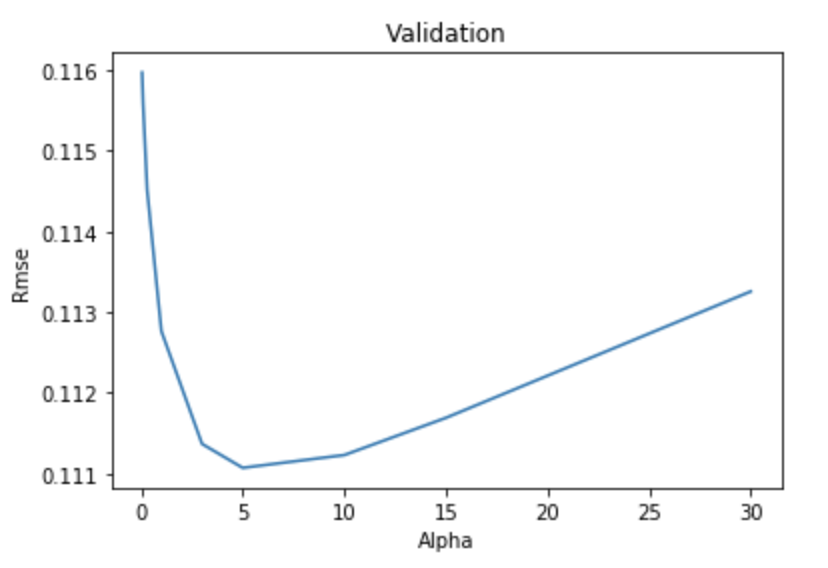

In [5]:
Image(filename = "ridge_regression.png", width=400, height=400)

In [ ]:
# 5 looks like the optimal alpha level, so let's fit the Ridge model with this value
model_ridge = Ridge(alpha = 5)

#### 2. Lasso Regression <i>(L1 regularisation)</i> 

Lasso stands for Least Absolute Shrinkage and Selection Operator. It shrinks the regression coefficients toward zero by penalizing the regression model with a penalty term called L1-norm, which is the sum of the absolute coefficients.

In the case of lasso regression, the penalty has the effect of forcing some of the coefficient estimates, with a minor contribution to the model, to be <b>exactly equal to zero</b>. This means that, lasso can be also seen as an alternative to the subset selection methods for performing variable selection in order to reduce the complexity of the model. For this reason, I usually prefer working with the Lasso algorithm over Ridge.

Let's take the same appraoch to alpha selection, before initiating the Lasso model.

In [ ]:
# Setting up list of alpha's
alphas = [0.01, 0.005, 0.001, 0.0005, 0.0001]

# Iterate over alpha's
cv_lasso = [rmse_cv(Lasso(alpha = alpha)).mean() for alpha in alphas]

# Plot findings
cv_lasso = pd.Series(cv_lasso, index = alphas)
cv_lasso.plot(title = "Validation")
plt.xlabel("Alpha")
plt.ylabel("Rmse")

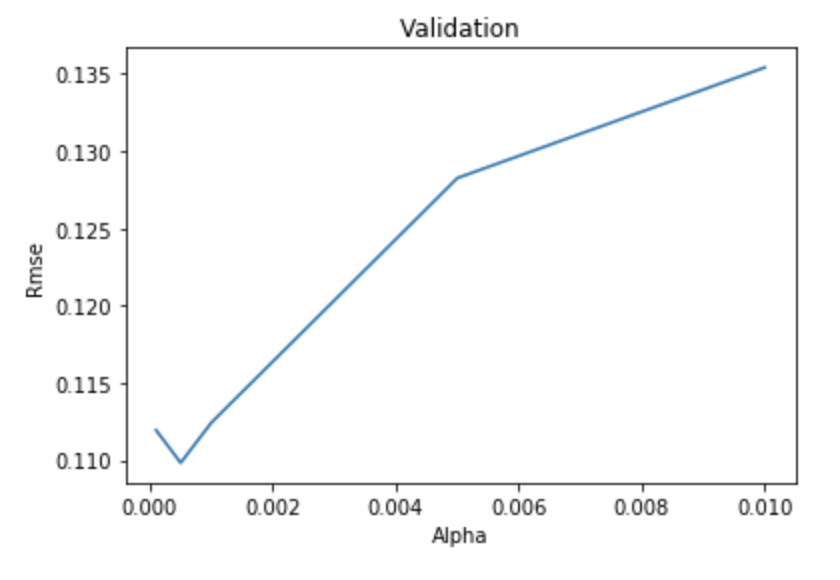

In [7]:
Image(filename = "lasso_regression.png", width=400, height=400)

An addition to the Lasso model - I will use a Pipeline to scale features. For the L1 norm to work properly, it's essential this step is taken before fitting the model.

In [ ]:
# Initiating Lasso model
model_lasso = make_pipeline(RobustScaler(), Lasso(alpha = 0.0005))

#### 3. ElasticNet Regression

Elastic Net produces a regression model that is penalized with both the L1-norm and L2-norm. The consequence of this is to effectively shrink coefficients (like in ridge regression) and to set some coefficients to zero (as in LASSO).

In [ ]:
# Setting up list of alpha's
alphas = [0.01, 0.005, 0.001, 0.0005, 0.0001]

# Iterate over alpha's
cv_elastic = [rmse_cv(ElasticNet(alpha = alpha)).mean() for alpha in alphas]

# Plot findings
cv_elastic = pd.Series(cv_elastic, index = alphas)
cv_elastic.plot(title = "Validation")
plt.xlabel("Alpha")
plt.ylabel("Rmse")

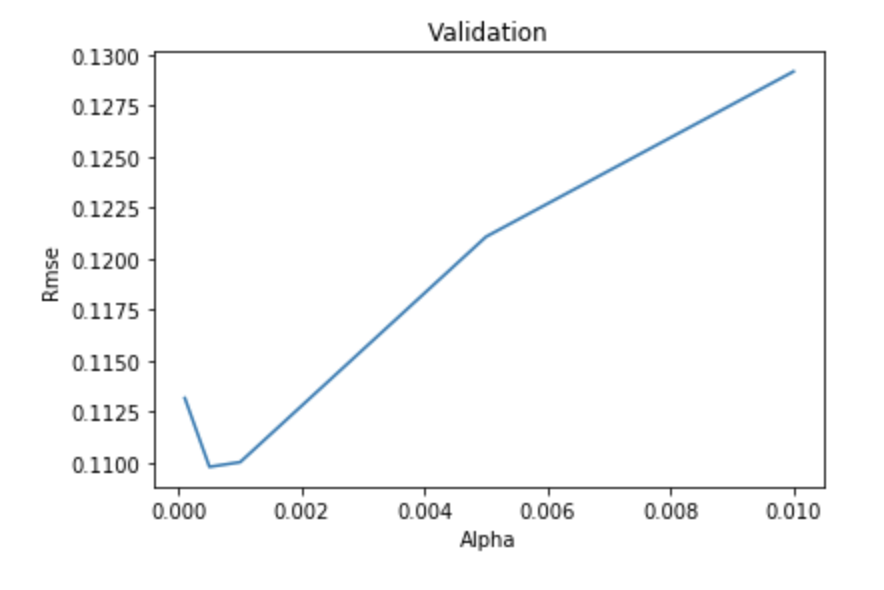

In [8]:
Image(filename = "elastic_net.png", width=400, height=400)

Again, i'll be using RobustScaler to scale all features before initiating the ElasticNet model.

In [ ]:
# Initiating ElasticNet model
model_elastic = make_pipeline(RobustScaler(), ElasticNet(alpha = 0.0005))

#### 4. Kernel ridge regression

OK, this is not strictly a generalized linear model. Kernel ridge regression (KRR) combines Ridge Regression (linear least squares with l2-norm regularization) with the 'kernel trick'. It thus learns a linear function in the space induced by the respective kernel and the data. For non-linear kernels, this corresponds to a non-linear function in the original space.

In [ ]:
# Setting up list of alpha's
alphas = [10, 9, 8, 7, 6, 5, 4, 3, 2, 1]

# Iterate over alpha's
cv_krr = [rmse_cv(KernelRidge(alpha = alpha)).mean() for alpha in alphas]

# Plot findings
cv_krr = pd.Series(cv_krr, index = alphas)
cv_krr.plot(title = "Validation")
plt.xlabel("Alpha")
plt.ylabel("Rmse")

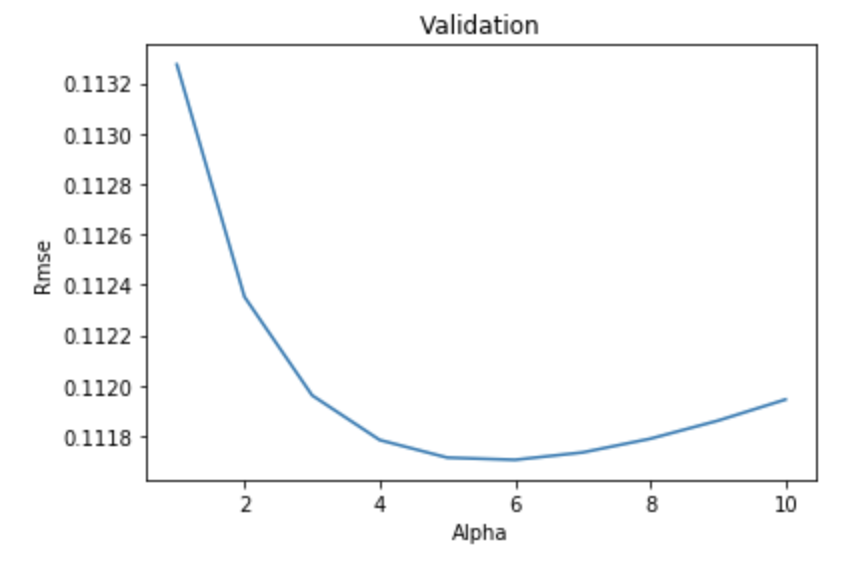

In [10]:
Image(filename = "kernel_ridge.png", width=400, height=400)

As well as scaling features again for the Kernel ridge regression, I've defined a few more parameters within this algorithm:

- Kernel: Polynomial
    - <i>This means that the algorithm will not just consider similarity between features, but also similarity           between combinations of features.</i>
- Degree & Coef0: 
    - <i>These are used to define the precise structure of the Polynomial kernel. I arrived at the below numbers          through a bit of trial and error. Implementing a GridSearchCV would probably yield a better overall fit.</i>

In [ ]:
# Initiatiing KernelRidge model
model_krr = make_pipeline(RobustScaler(), KernelRidge(alpha=6, kernel='polynomial', degree=2.65, coef0=6.9))

### B. Ensemble methods (Gradient tree boosting)

Boosting is an ensemble technique in which the predictors are not made independently, but sequentially.

This technique employs the logic in which the subsequent predictors learn from the mistakes of the previous predictors. Therefore, the observations have an unequal probability of appearing in subsequent models and ones with the highest error appear most. The predictors can be chosen from a range of models like decision trees, regressors, classifiers etc. Because new predictors are learning from mistakes committed by previous predictors, it takes less time/iterations to reach close to actual predictions. But we have to choose the stopping criteria carefully or it could lead to overfitting on training data. Gradient Boosting is an example of a boosting algorithm, and these are what i'll be applying to the current data next.

#### 5. Gradient Boosting

For the Gradient Boosting algorithm I will use 'huber' as the loss function as this is robust to outliers. The other parameters on display originate from other kernels tackling this challenge, followed by trial and error to refine them to this specific dataset. Again, applying GridSearchCV will help to define a better set of parameters than those currently on display.

For the Gradient Boosting model I will use 'huber' as the loss function as this is robust to outliers.

In [ ]:
# Initiating Gradient Boosting Regressor
model_gbr = GradientBoostingRegressor(n_estimators=1200, 
                                      learning_rate=0.05,
                                      max_depth=4, 
                                      max_features='sqrt',
                                      min_samples_leaf=15, 
                                      min_samples_split=10, 
                                      loss='huber',
                                      random_state=5)

#### 6. XGBoost

Another gradient boosting algorithm; one that's well documented as being the key to many winning solutions on Kaggle.

In [ ]:
# Initiating XGBRegressor
model_xgb = xgb.XGBRegressor(colsample_bytree=0.2,
                             learning_rate=0.06,
                             max_depth=3,
                             n_estimators=1150)

#### 7. LightGBM

A more recent gradient boosting algorithm which boasts significantly faster runtime than XGBoost, while still offering best-in-class predictive power.

In [ ]:
# Initiating LGBMRegressor model
model_lgb = lgb.LGBMRegressor(objective='regression',
                              num_leaves=4,
                              learning_rate=0.05, 
                              n_estimators=1080,
                              max_bin=75, 
                              bagging_fraction=0.80,
                              bagging_freq=5, 
                              feature_fraction=0.232,
                              feature_fraction_seed=9, 
                              bagging_seed=9,
                              min_data_in_leaf=6, 
                              min_sum_hessian_in_leaf=11)

#### 8. CatBoost

All the way from Russia, CatBoost is a new gradient boosting algorithm able to work with categorical features <b>without</b> any prior processing needed. It's also quick, very quick. I am still finding my feet with implementing the CatBoostRegressor - thus this section of the kernel is very much a work in progress. Any guidance on working with this algorithm would be greatly appreciated - especially with regards to performing cross-validation and hyperparameter tuning. The below parameters again came from my own trial & error.

In [ ]:
# Initiating CatBoost Regressor model
model_cat = CatBoostRegressor(iterations=2000,
                              learning_rate=0.10,
                              depth=3,
                              l2_leaf_reg=4,
                              border_count=15,
                              loss_function='RMSE',
                              verbose=200)

<a id='FA'></a>
## 2. Fitting algorithms


### Fit all models

I'll now run the custom rmse_cv function on each algorithm to understand each model's performance. This function doesn't work for the CatBoost algorithm, so I will just fit this for now and will return with a solution at a later date.

In [ ]:
# Fitting all models with rmse_cv function, apart from CatBoost (still yet to crack this so performaing a simple fit for now)
cv_ridge = rmse_cv(model_ridge).mean()
cv_lasso = rmse_cv(model_lasso).mean()
cv_elastic = rmse_cv(model_elastic).mean()
cv_krr = rmse_cv(model_krr).mean()
cv_gbr = rmse_cv(model_gbr).mean()
cv_xgb = rmse_cv(model_xgb).mean()
cv_lgb = rmse_cv(model_lgb).mean()
cv_cat = model_cat.fit(X_train, y_train)

### Rank model performance

The moment of truth - let's see how each algorithm has performed, and which one tops the pile.

In [ ]:
# Creating a table of results, ranked highest to lowest
results = pd.DataFrame({
    'Model': ['Ridge',
              'Lasso',
              'ElasticNet',
              'Gradient Boosting Regressor',
              'XGBoost Regressor',
              'Light Gradient Boosting Regressor',
              'CatBoost'],
    'Score': [cv_ridge,
              cv_lasso,
              cv_elastic,
              cv_gbr,
              cv_xgb,
              cv_lgb,
              cv_cat.score(X_train, y_train)]})

# Build dataframe of values
result_df = results.sort_values(by='Score', ascending=True).reset_index()
result_df.head(8)

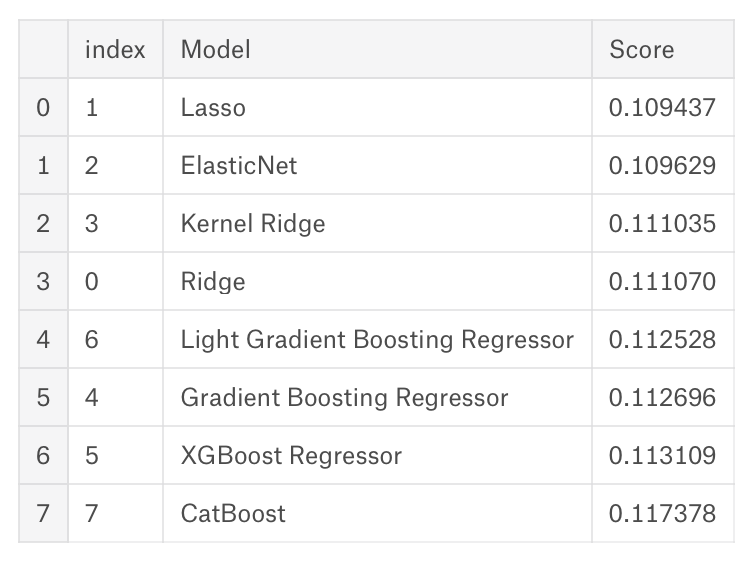

In [11]:
Image(filename = "model_performance.png", width=400, height=400)

In [ ]:
# Plotting model performance
f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation='90')
sns.barplot(x=result_df['Model'], y=result_df['Score'])
plt.xlabel('Models', fontsize=15)
plt.ylabel('Model performance', fontsize=15)
plt.ylim(0.10, 0.115)
plt.title('RMSE', fontsize=15)

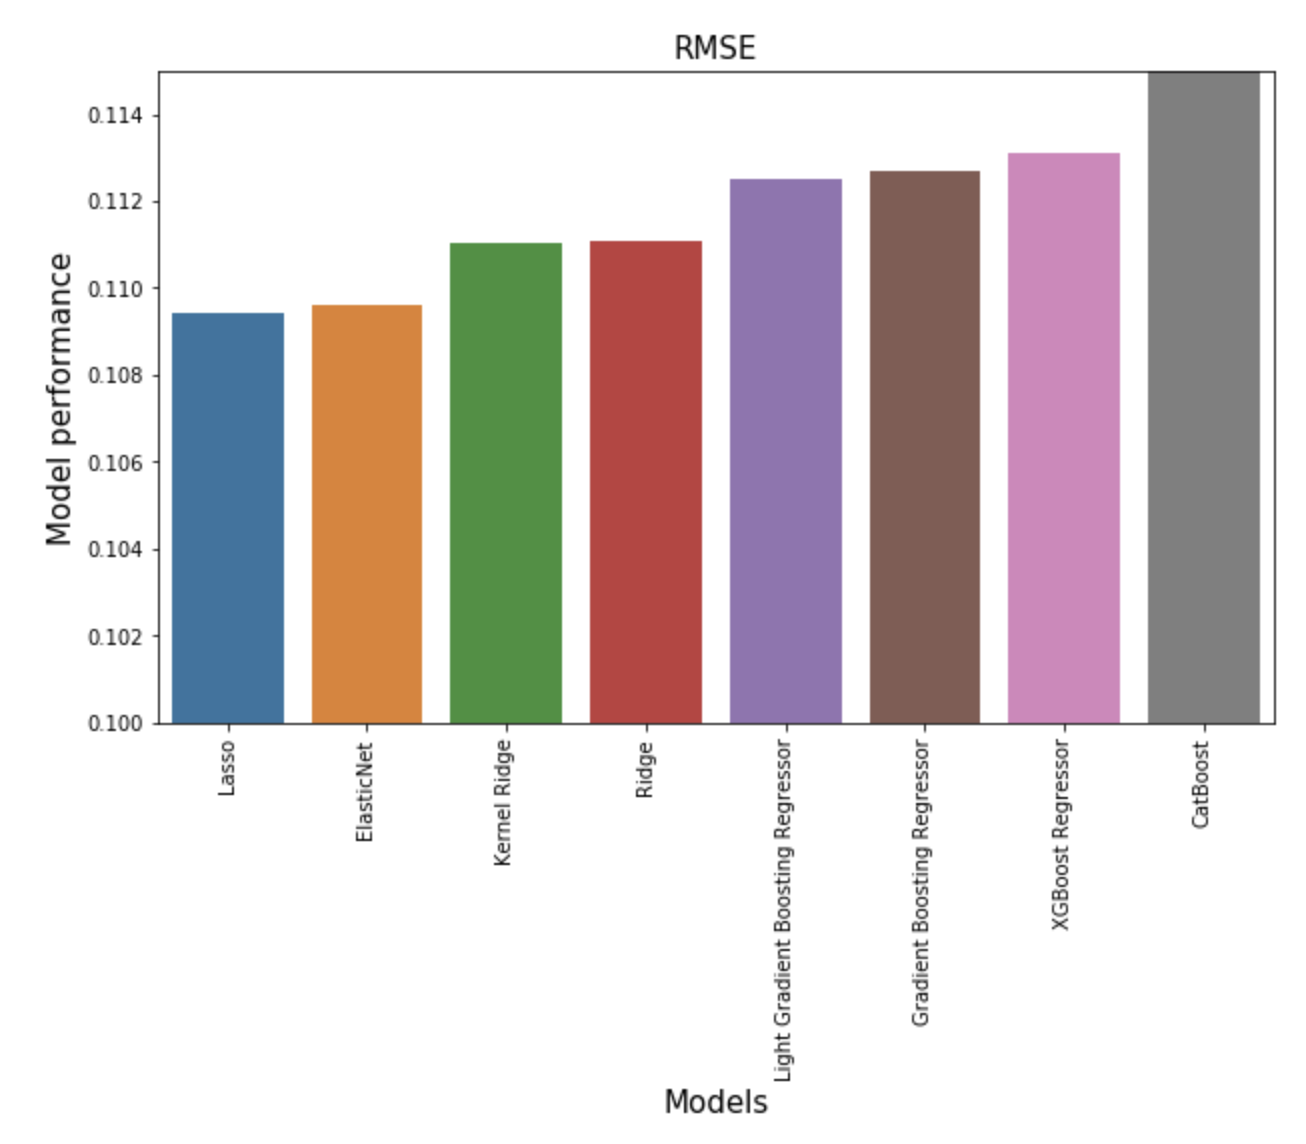

In [14]:
Image(filename = "performance_plot.png", width=600, height=600)

We can see from the above graph that the LASSO and ElasticNet are the best cross-validated models, scoring very closely to one another. Gradient boosting hasn't fared quite as well, however each algorithm still obtains a very respectable RMSE. The CatBoost model has not been cross-validated so I am not going to consider this algorithm (for the time being).

<a id='SA'></a>
## 3. Stacking algorithms

I've ran eight models thus far, and they've all performed pretty well. I'm now quite keen to explore stacking as a means of achieving an even higher score. In a nutshell, stacking uses as a first-level (base) the predictions of a few basic classifiers and then uses another model at the second-level to predict the output from the earlier first-level predictions. Stacking can be beneficial as combining models allows the best elements of their predictive power on the given challenged to be pooled, thus smoothing over any gaps left from an individual model and increasing the likelihood of stronger overall model performance.

Ok, let's get model predictions and then stack the results!

In [ ]:
# Fit and predict all models
model_lasso.fit(X_train, y_train)
lasso_pred = np.expm1(model_lasso.predict(X_test))

model_elastic.fit(X_train, y_train)
elastic_pred = np.expm1(model_elastic.predict(X_test))

model_ridge.fit(X_train, y_train)
ridge_pred = np.expm1(model_ridge.predict(X_test))

model_xgb.fit(X_train, y_train)
xgb_pred = np.expm1(model_xgb.predict(X_test))

model_gbr.fit(X_train, y_train)
gbr_pred = np.expm1(model_gbr.predict(X_test))

model_lgb.fit(X_train, y_train)
lgb_pred = np.expm1(model_lgb.predict(X_test))

model_krr.fit(X_train, y_train)
krr_pred = np.expm1(model_krr.predict(X_test))

model_cat.fit(X_train, y_train)
cat_pred = np.expm1(model_cat.predict(X_test))

In [ ]:
features_imp = pd.DataFrame()
features_imp['features'] = list(feature_columns)[:]
features_imp['importance'] = lgb_clf.feature_importances_
features_imp = features_imp.sort_values(by='importance', ascending=False).reset_index()

y_plot = -np.arange(15)
plt.figure(figsize=(10,6))
plt.barh(y_plot, features_imp.loc[:14,'importance'].values)
plt.yticks(y_plot,(features_imp.loc[:14,'features']))
plt.xlabel('Feature importance')
plt.title('Features importance')
plt.tight_layout()

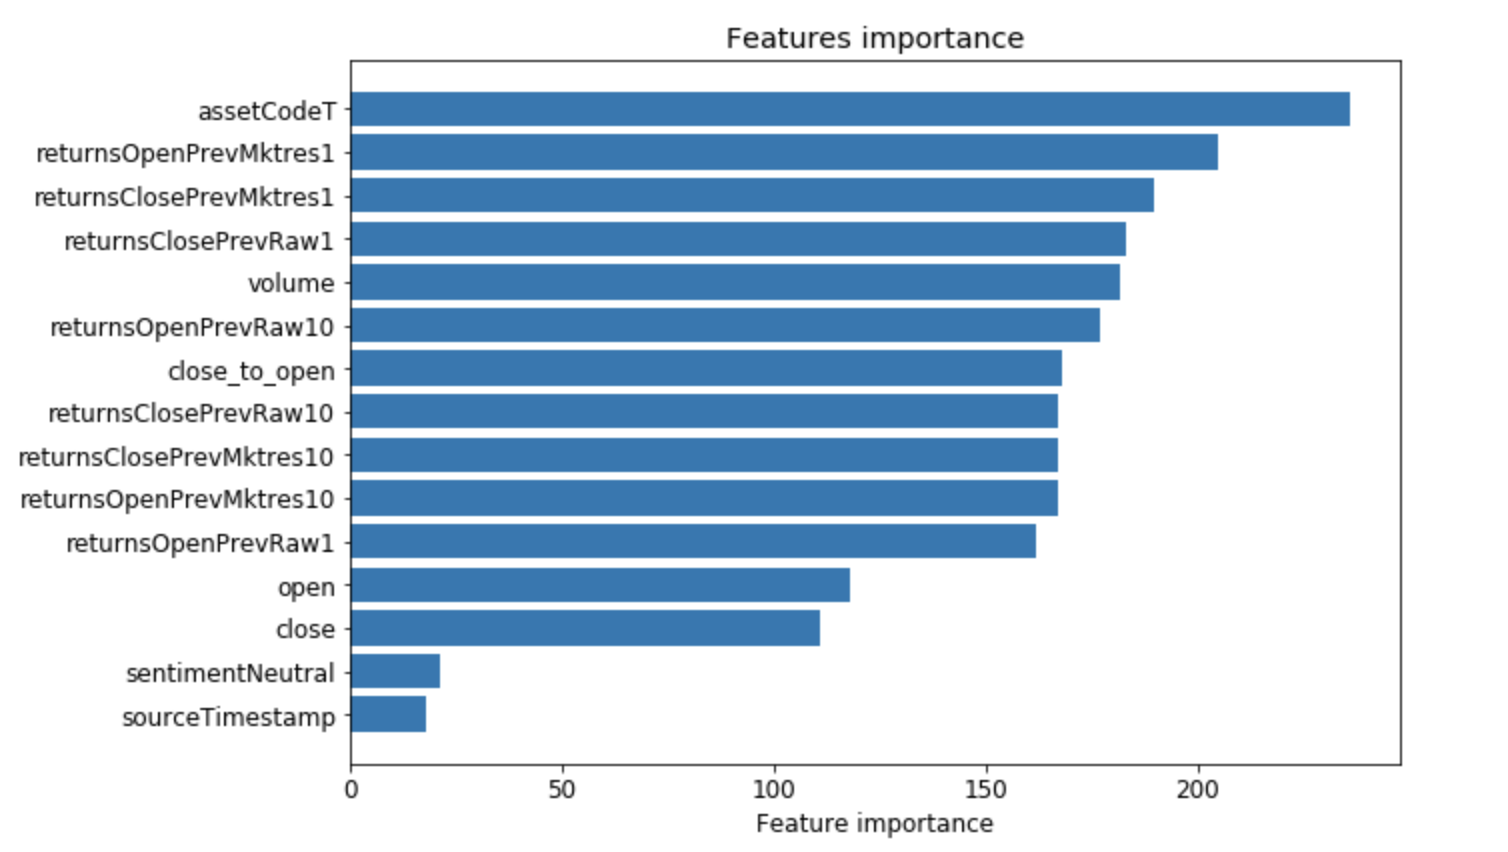

In [19]:
Image(filename = "features_importance.png", width=600, height=600)

<a id='FP'></a>
## Final predictions

In [ ]:
# Create stacked model
stacked = (lasso_pred + elastic_pred + ridge_pred + xgb_pred + lgb_pred + krr_pred + gbr_pred) / 7
days = env.get_prediction_days()
n_days = 0
prep_time = 0
prediction_time = 0
packaging_time = 0
for (market_obs_df, news_obs_df, predictions_template_df) in days:
    n_days +=1
    if n_days % 50 == 0:
        print(n_days,end=' ')

    t = time.time()
    column_market = ['returnsClosePrevMktres1','returnsOpenPrevMktres1','returnsClosePrevMktres10', 'returnsOpenPrevMktres10']
    column_raw = ['returnsClosePrevRaw1', 'returnsOpenPrevRaw1','returnsClosePrevRaw10', 'returnsOpenPrevRaw10']
    market_obs_df['close_open_ratio'] = np.abs(market_obs_df['close']/market_obs_df['open'])
    for i in range(len(column_raw)):
        market_obs_df[column_market[i]] = market_obs_df[column_market[i]].fillna(market_obs_df[column_raw[i]])

    market_obs_df = market_obs_df[market_obs_df.assetCode.isin(predictions_template_df.assetCode)]
    market_obs_df = market_obs_df[market_obs_df.assetCode.isin(asset_code_dict.keys())]
    market_obs = data_prep(market_obs_df, news_obs_df)
    market_obs[num_columns] = data_scaler.transform(market_obs[num_columns])
    X_live = market_obs[feature_columns].values
    prep_time += time.time() - t

    t = time.time()
    lp = vc.predict_proba(X_live)
    prediction_time += time.time() -t

    t = time.time()
    confidence = lp[:,1] - lp[:,0]
    #confidence = confidence_out(lp)
    confidence = rescale(confidence, r_train)
    preds = pd.DataFrame({'assetCode':market_obs['assetCode'],'confidence':confidence})
    predictions_template_df = predictions_template_df.merge(preds,how='left').drop('confidenceValue',axis=1).fillna(0).rename(columns={'confidence':'confidenceValue'})
    env.predict(predictions_template_df)
    packaging_time += time.time() - t

In [ ]:
plt.hist(confidence, bins='auto')
plt.title("predicted confidence")
plt.show()

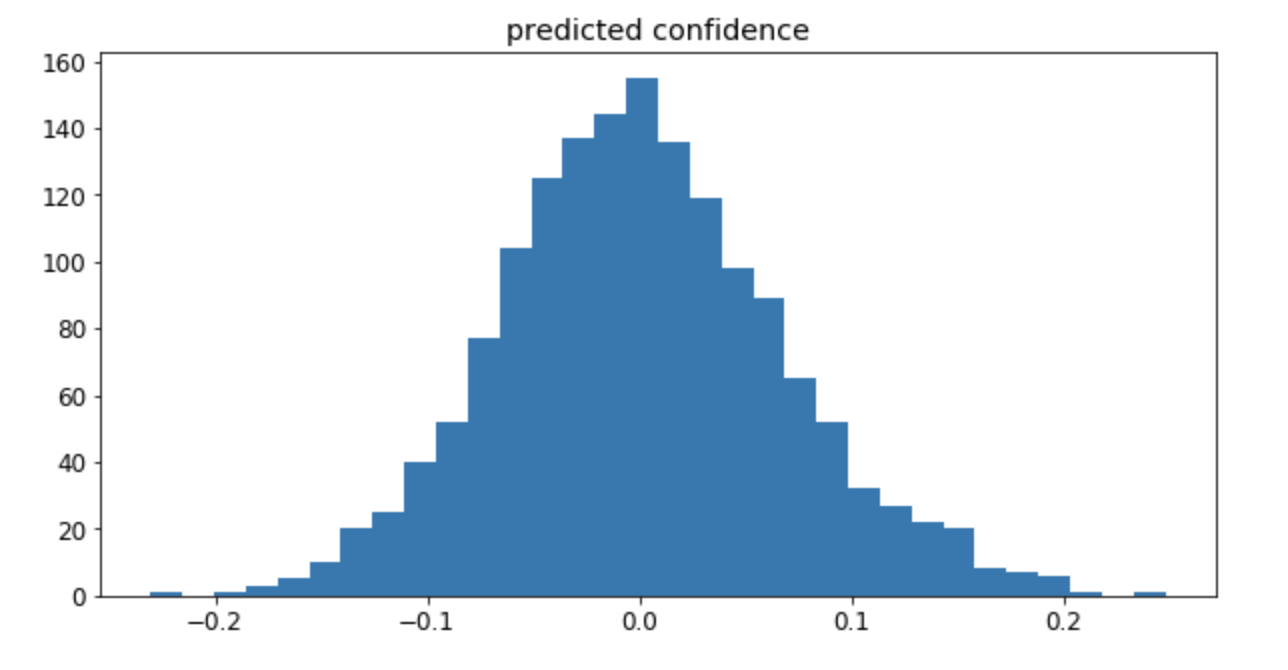

In [17]:
Image(filename = "predicted_confidence.png", width=600, height=600)

# Conclusion
This concludes our work for this problem. We hope the approach and techniques on display in this notebook have been helpful in terms of not just solving the current challenges, but other regression and broader machine learning challenges.

If this notebook has indeed enlighten you - we'd love to hear it :). Please also share with us any suggestions that could improve our models, as we are always looking to learn more. In terms of future version, we aim to tackle the following:
* Parameter tuning the models
* Performing a more rigorous GridSearchCV
* Exploring more complex methods of model stacking for better final prediction.

Thank you for reading :) 

### Special Notes
* we only have sample dataset. The complete dataset can be accessed through the platform(kaggle) and cannot be downloaded. Thus we run all the codes on the platform.
* Due to the limitation of RAM, we cannot run the code in one file. Thus, for the model part, we can only show the images from local file.